<a href="https://colab.research.google.com/github/piotrblazejewski/uczeniemaszynowe/blob/1/Case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import bibliotek i wczytywanie pliku

import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('/content/drive/MyDrive/Cwiczenia/transaction_dataset.csv').drop(columns=['Unnamed: 0'])
df.columns

Index(['Index', 'Address', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time betwe

In [ ]:
# Tworzenie listy kolumn, które zawierają tylko zerowe wartości
columns_to_drop = []
for i in list(df.columns):
    if df[i].dropna().unique().tolist() == df[' ERC20 avg val sent contract'].dropna().unique().tolist():
        columns_to_drop.append(i)
columns_to_drop

[' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract']

In [ ]:
# Tworzenie listy kolumn do usunięcia
col_del = ['Address','Index']+columns_to_drop
print(col_del)

['Address', 'Index', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']


In [ ]:
# Usuwanie niepotrzebnych kolumn
df_new = df.drop(columns=col_del)

In [ ]:
# Wypełnianie brakujących numerycznych wartości ich średnią
for i in list(df_new.columns):
  if i not in [' ERC20 most sent token type', ' ERC20_most_rec_token_type']:
    mean = np.mean(df_new[i])
    df_new[i] = df_new[i].fillna(mean)
df_new.isna().sum()

FLAG                                                      0
Avg min between sent tnx                                  0
Avg min between received tnx                              0
Time Diff between first and last (Mins)                   0
Sent tnx                                                  0
Received Tnx                                              0
Number of Created Contracts                               0
Unique Received From Addresses                            0
Unique Sent To Addresses                                  0
min value received                                        0
max value received                                        0
avg val received                                          0
min val sent                                              0
max val sent                                              0
avg val sent                                              0
min value sent to contract                                0
max val sent to contract                

In [ ]:
# Wypełnianie brakujących wartości nienumerycznych najczęściej występującą instacją
df_new[' ERC20_most_rec_token_type']=df_new[' ERC20_most_rec_token_type'].fillna('0')
df_new[' ERC20 most sent token type'] = df_new[' ERC20 most sent token type'].fillna('0')
df_new.isna().sum()

FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent to contract                              0
max val sent to contract                                0
avg value sent

In [ ]:
# Tworzenie list kategorii
features = list(set(df_new.columns) - set('FLAG'))
num_features = list(set(features) - set(df_new.dtypes[df.dtypes == 'object'].index))
cat_feature = list(set(features) - set(num_features))

<ipython-input-421-5ead87909094>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_new[features + ['FLAG']].corr()


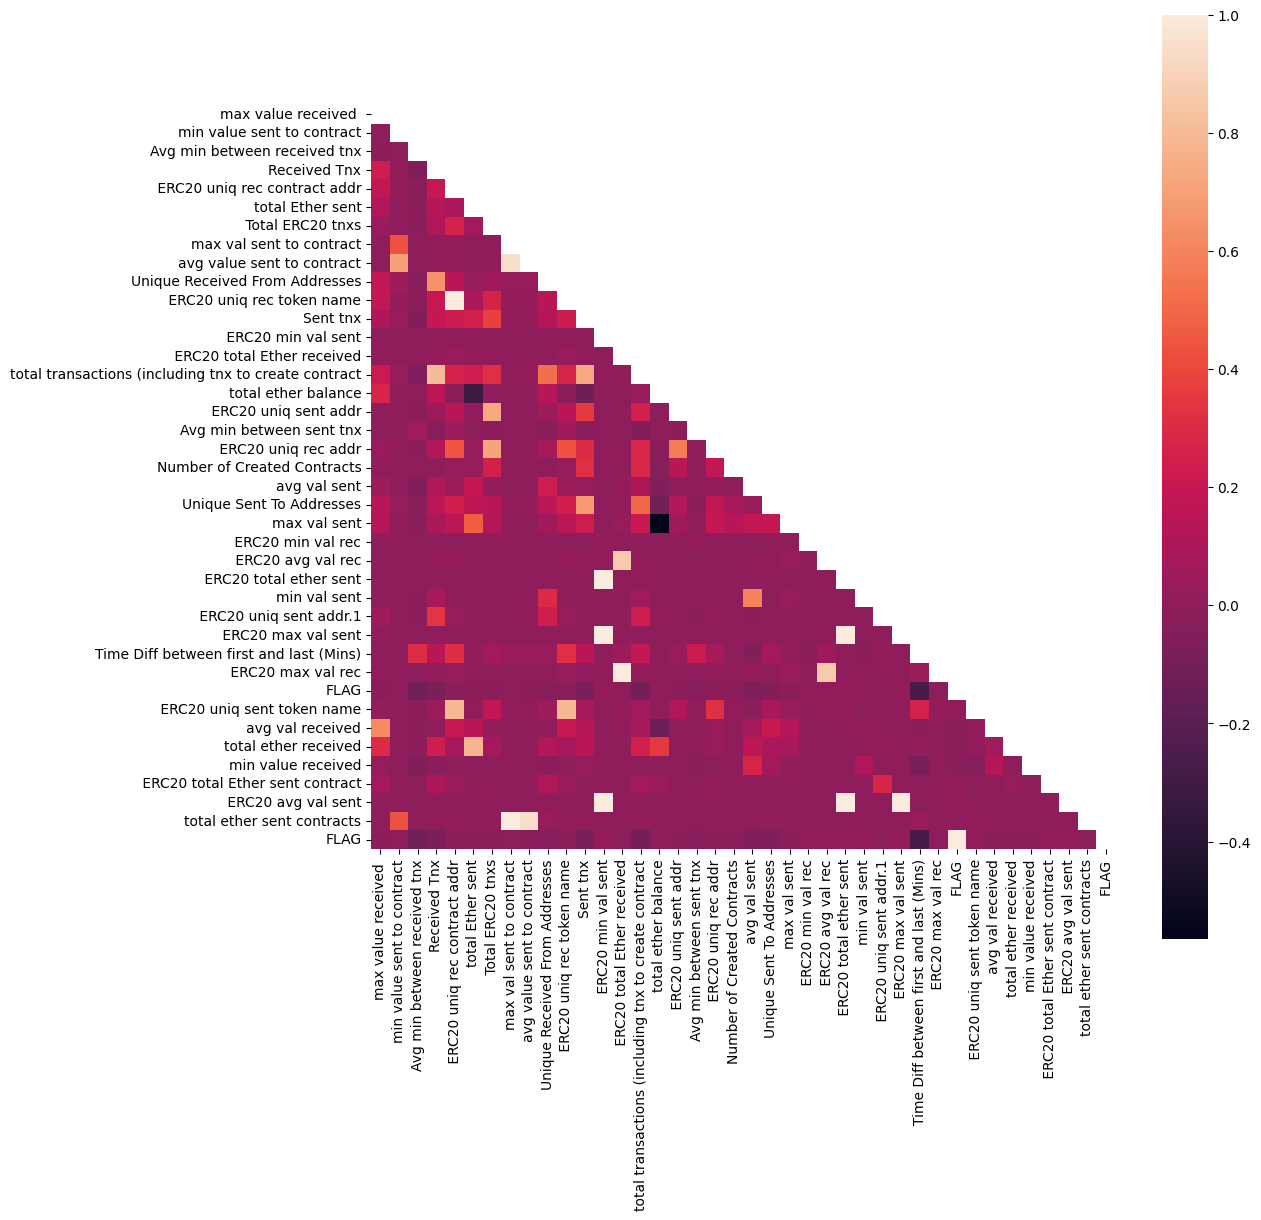

In [ ]:
# Tworzenie mapy korelacji
corr = df_new[features + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True)
plt.show()

In [ ]:
# Usuwanie wysoko skorelowanych zmiennych
threshold = 0.8

high_corr_var = np.where((corr.abs() > threshold) & (corr.abs() < 1))
high_corr_pairs = [(corr.columns[x], corr.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

for (column1, column2) in high_corr_pairs:
    if column1 in df_new.columns and column2 in df_new.columns:
        df_new.drop(column2, axis=1, inplace=True)

df_new.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'total Ether sent', 'total ether received', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
       ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1',
       ' ERC20 uniq rec contract addr', ' ERC20 min val rec',
       ' ERC20 min val sent', ' ERC20 uniq sent token name',
       ' ERC20 most sent token type', ' ERC20_most_rec_token_type'],
      dtype='object')

In [ ]:
# Tworzenie nowej listy kategorii
features = list(set(df_new.columns) - set('FLAG'))
num_features = list(set(features) - set(df_new.dtypes[df.dtypes == 'object'].index))
cat_feature = list(set(features) - set(num_features))

<ipython-input-424-b6b3f1028e4a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_new[features + ['FLAG']].corr()


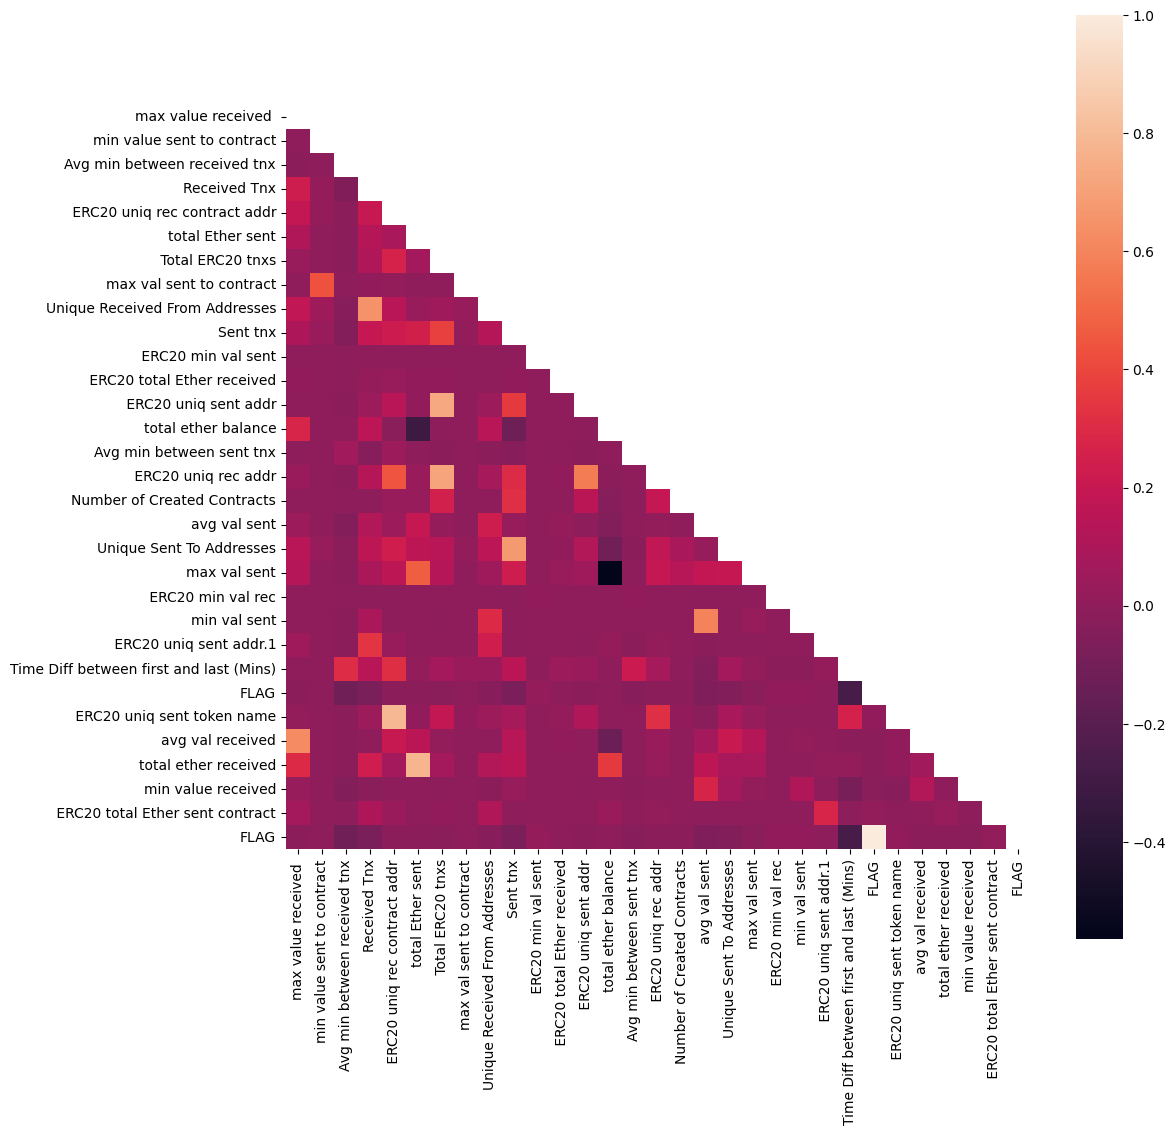

In [ ]:
# Tworzenie nowej mapy korelacji
corr = df_new[features + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True)
plt.show()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'max value received '),
  Text(1, 0, 'min value sent to contract'),
  Text(2, 0, 'Avg min between received tnx'),
  Text(3, 0, 'Received Tnx'),
  Text(4, 0, ' ERC20 uniq rec contract addr'),
  Text(5, 0, 'total Ether sent'),
  Text(6, 0, ' Total ERC20 tnxs'),
  Text(7, 0, 'max val sent to contract'),
  Text(8, 0, 'Unique Received From Addresses'),
  Text(9, 0, 'Sent tnx'),
  Text(10, 0, ' ERC20 min val sent'),
  Text(11, 0, ' ERC20 total Ether received'),
  Text(12, 0, ' ERC20 uniq sent addr'),
  Text(13, 0, 'total ether balance'),
  Text(14, 0, ' ERC20 uniq rec addr'),
  Text(15, 0, 'Avg min between sent tnx'),
  Text(16, 0, 'Number of Created Contracts'),
  Text(17, 0, 'avg val sent'),
  Text(18, 0, 'Unique Sent To Addresses'),
  Text(19, 0, 'max val sent'),
  Text(20, 0, ' ERC20 min val rec'),
  Text(2

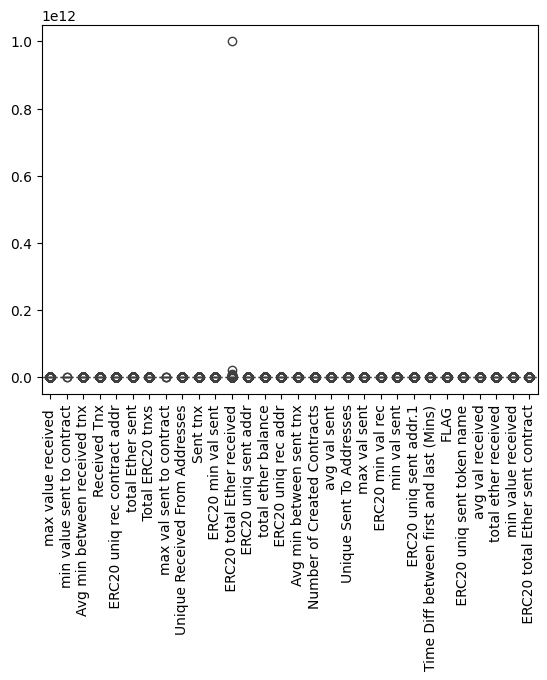

In [ ]:
# Tworzenie boxplotu ukazującego wartości odstające
def boxy(df, col):
  return sns.boxplot(df[col])
boxy(df_new, num_features)
plt.xticks(rotation=90)

<Axes: ylabel=' ERC20 total Ether received'>

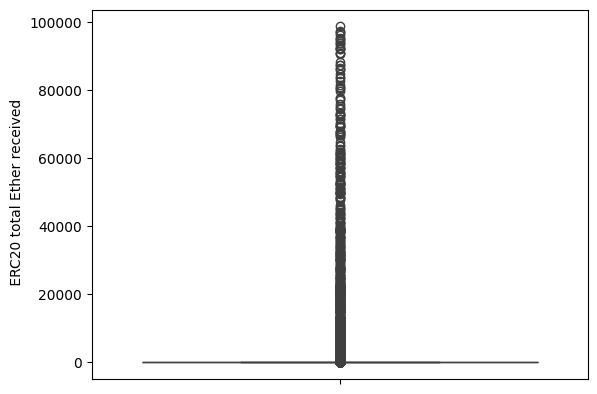

In [ ]:
# Metoda IQR zamienia zbyt dużo wartości w 0
# Ręczne usuwanie esktremalnych wartości odstających
df_new = df_new[df_new[' ERC20 total Ether received']< 100000]
sns.boxplot(x[' ERC20 total Ether received'])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 [Text(1, 0, 'FLAG'),
  Text(2, 0, 'Avg min between sent tnx'),
  Text(3, 0, 'Avg min between received tnx'),
  Text(4, 0, 'Time Diff between first and last (Mins)'),
  Text(5, 0, 'Sent tnx'),
  Text(6, 0, 'Received Tnx'),
  Text(7, 0, 'Number of Created Contracts'),
  Text(8, 0, 'Unique Received From Addresses'),
  Text(9, 0, 'Unique Sent To Addresses'),
  Text(10, 0, 'min value received'),
  Text(11, 0, 'max value received '),
  Text(12, 0, 'avg val received'),
  Text(13, 0, 'min val sent'),
  Text(14, 0, 'max val sent'),
  Text(15, 0, 'avg val sent'),
  Text(16, 0, 'min value sent to contract'),
  Text(17, 0, 'max val sent to contract'),
  Text(18, 0, 'total Ether sent'),
  Text(19, 0, 'total ether received'),
  Text(20, 0, 'total ether balance'),
  Text(21, 0, ' Total ERC20 tnxs'),
  Text(22, 0, ' ERC20 total Ether received'),
  Text(23, 0, ' ERC

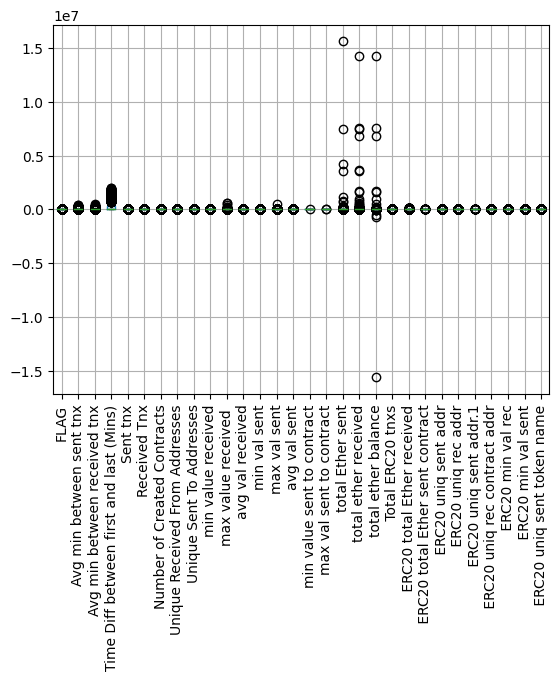

In [ ]:
# Ręczne usuwanie esktremalnych wartości odstających
df_new = df_new[df_new[' ERC20 min val sent']<10000]
df_new.boxplot()
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 [Text(1, 0, 'FLAG'),
  Text(2, 0, 'Avg min between sent tnx'),
  Text(3, 0, 'Avg min between received tnx'),
  Text(4, 0, 'Time Diff between first and last (Mins)'),
  Text(5, 0, 'Sent tnx'),
  Text(6, 0, 'Received Tnx'),
  Text(7, 0, 'Number of Created Contracts'),
  Text(8, 0, 'Unique Received From Addresses'),
  Text(9, 0, 'Unique Sent To Addresses'),
  Text(10, 0, 'min value received'),
  Text(11, 0, 'max value received '),
  Text(12, 0, 'avg val received'),
  Text(13, 0, 'min val sent'),
  Text(14, 0, 'max val sent'),
  Text(15, 0, 'avg val sent'),
  Text(16, 0, 'min value sent to contract'),
  Text(17, 0, 'max val sent to contract'),
  Text(18, 0, 'total Ether sent'),
  Text(19, 0, 'total ether received'),
  Text(20, 0, 'total ether balance'),
  Text(21, 0, ' Total ERC20 tnxs'),
  Text(22, 0, ' ERC20 total Ether received'),
  Text(23, 0, ' ERC

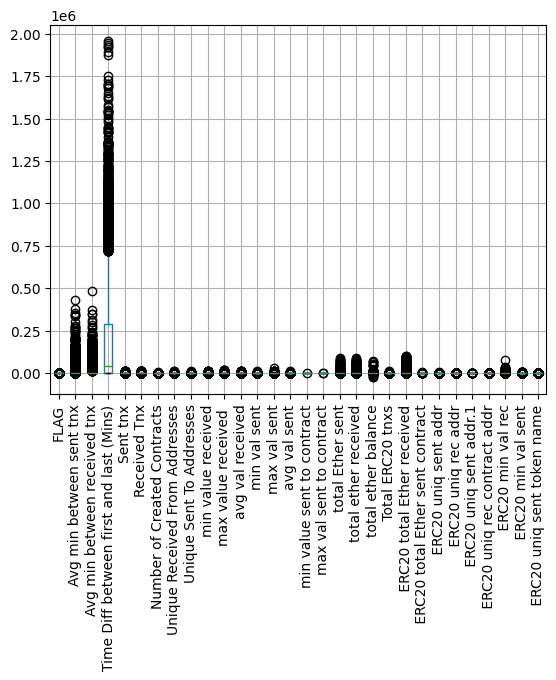

In [ ]:
# Ręczne usuwanie esktremalnych wartości odstających
col_list = ['total Ether sent', 'total ether received', 'total ether balance']
for col in col_list:
  df_new = df_new[df_new[col]<100000]
df_new.boxplot()
df_new.shape
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 [Text(1, 0, 'FLAG'),
  Text(2, 0, 'Avg min between sent tnx'),
  Text(3, 0, 'Avg min between received tnx'),
  Text(4, 0, 'Time Diff between first and last (Mins)'),
  Text(5, 0, 'Sent tnx'),
  Text(6, 0, 'Received Tnx'),
  Text(7, 0, 'Number of Created Contracts'),
  Text(8, 0, 'Unique Received From Addresses'),
  Text(9, 0, 'Unique Sent To Addresses'),
  Text(10, 0, 'min value received'),
  Text(11, 0, 'max value received '),
  Text(12, 0, 'avg val received'),
  Text(13, 0, 'min val sent'),
  Text(14, 0, 'max val sent'),
  Text(15, 0, 'avg val sent'),
  Text(16, 0, 'min value sent to contract'),
  Text(17, 0, 'max val sent to contract'),
  Text(18, 0, 'total Ether sent'),
  Text(19, 0, 'total ether received'),
  Text(20, 0, 'total ether balance'),
  Text(21, 0, ' Total ERC20 tnxs'),
  Text(22, 0, ' ERC20 total Ether received'),
  Text(23, 0, ' ERC

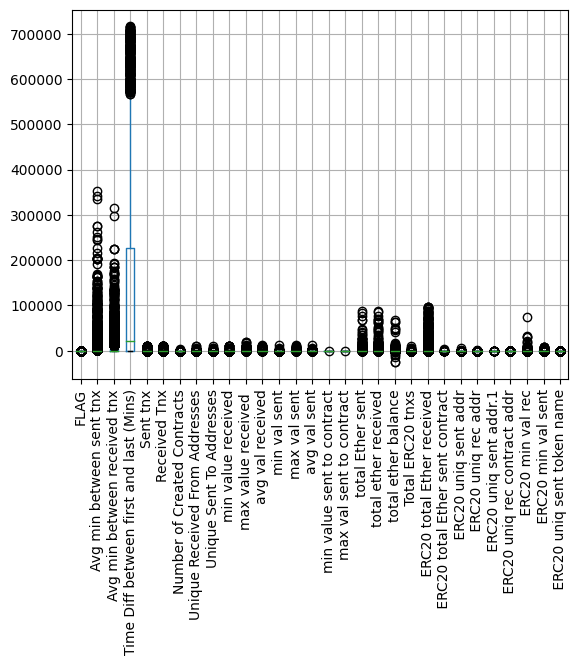

In [ ]:
# Metoda IQR dla jednej z kolumn
Q1 = df_new['Time Diff between first and last (Mins)'].quantile(0.25)
Q3 = df_new['Time Diff between first and last (Mins)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_new = df_new[(df_new['Time Diff between first and last (Mins)'] >= lower_bound) & (df_new['Time Diff between first and last (Mins)'] <= upper_bound)]
df_new.boxplot()
plt.xticks(rotation=90)

In [ ]:
# Ujednolicenie wartości
df_new[' ERC20_most_rec_token_type'] = df_new[' ERC20_most_rec_token_type'].replace(['None', ' ', None], '0')
df_new[' ERC20_most_rec_token_type'].unique()

array(['XENON', '0', 'AICRYPTO', 'DATAcoin', 'PoSToken', 'OmiseGO',
       'ONOT', 'SAFE.AD - 20% DISCOUNT UNTIL 1 MAY', 'bitqy', 'Tronix',
       'StatusNetwork', 'INS Promo', 'TenXPay', 'FunFair',
       'iEx.ec Network Token', 'AION', 'Aragon', 'Bancor', 'Golem',
       'CRYPTOPUNKS', 'VeChain', 'Intelion', 'Dochain', 'Humaniq', 'DGD',
       'BOX Token', 'MobileGo', 'Nexium', 'www.pnztrust.com',
       'An Etheal Promo', 'SwarmCity', 'BitClave', 'Bytom', 'EOS',
       'Livepeer Token', 'Celsius', 'Trustcoin', 'Reputation', 'Salt',
       'ICONOMI', 'Edgeless', 'Guaranteed Entrance Token', 'Telcoin',
       'DICE', 'Polybius', 'Hut34 Entropy', 'BAT', 'TokenCard', 'SNGLS',
       'blockwell.ai KYC Casper Token', 'KickCoin', 'Oyster Pearl',
       'ethBo', 'Qtum', 'Delphy Token', 'BlitzPredict', 'Storj',
       'Populous', 'Monaco', 'Veritaseum', 'Soarcoin', 'TAAS',
       'KyberNetwork', 'StatusGenesis', 'AnyCoinVer10', 'OpenANX',
       'UnityIngot', 'Amber', 'WAX Token', 'WisePlat 

In [ ]:
# Zamiana wartości kolumn kategorycznych na 0 i 1
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_new[cat_feature])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(cat_feature), index=df_new.index)
df_new.drop(cat_feature, axis=1, inplace=True)
df_new = pd.concat([df_new, encoded_df], axis=1)
df_new.isna().sum()

FLAG                                           0
Avg min between sent tnx                       0
Avg min between received tnx                   0
Time Diff between first and last (Mins)        0
Sent tnx                                       0
                                              ..
 ERC20_most_rec_token_type_savedroid           0
 ERC20_most_rec_token_type_shellchains.com     0
 ERC20_most_rec_token_type_vSlice              0
 ERC20_most_rec_token_type_www.pnztrust.com    0
 ERC20_most_rec_token_type_yocoinclassic       0
Length: 416, dtype: int64

In [ ]:
# Standaryzacja danych
X = df_new.drop('FLAG', axis=1)
y = df_new['FLAG']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20_most_rec_token_type_ethBo,ERC20_most_rec_token_type_freetoken.pro,ERC20_most_rec_token_type_iEx.ec Network Token,ERC20_most_rec_token_type_iXledger,ERC20_most_rec_token_type_minereum,ERC20_most_rec_token_type_savedroid,ERC20_most_rec_token_type_shellchains.com,ERC20_most_rec_token_type_vSlice,ERC20_most_rec_token_type_www.pnztrust.com,ERC20_most_rec_token_type_yocoinclassic
0,12.546486,-0.225494,2.236225,-0.094260,-0.115323,-0.018657,-0.031235,-0.046616,-0.152340,-0.207575,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
1,0.308017,0.516715,1.554402,-0.047534,-0.116736,-0.018657,-0.044097,0.014966,-0.152650,0.542744,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
2,0.291448,-0.339932,-0.600394,-0.094260,-0.125215,-0.018657,-0.065534,-0.052214,-0.150668,-0.202087,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
3,-0.218404,-0.325814,-0.670573,-0.047534,-0.113909,-0.018657,-0.035523,0.054154,-0.152516,-0.205342,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
4,-0.144347,-0.350975,1.109701,0.334402,-0.122388,-0.018657,-0.061246,-0.041018,-0.152326,-0.206320,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7584,-0.222007,-0.360806,-0.720121,-0.098323,-0.129454,-0.018657,-0.074108,-0.057813,-0.152650,-0.209328,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
7585,0.433293,-0.325706,-0.384005,-0.090197,-0.111083,-0.018657,-0.026948,-0.035419,-0.152639,-0.191278,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
7586,-0.222007,-0.360806,-0.720121,-0.098323,-0.129454,-0.018657,-0.074108,-0.057813,-0.152650,-0.209328,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148
7587,-0.092377,-0.239099,0.776573,0.037792,-0.068689,-0.018657,0.058798,0.188514,-0.152647,-0.177275,...,-0.01148,-0.01148,-0.01148,-0.01148,-0.022964,-0.01148,-0.016236,-0.01148,-0.04876,-0.01148


In [ ]:
# Poszukiwanie optymalnej liczby komponentów
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_components_optimal = (total_explained_variance >= 0.95).argmax() + 1

n_components_optimal

290

In [ ]:
# Wykonanie PCA z optymalną liczbą komponentów
pca_optimal = PCA(n_components=n_components_optimal)

X_pca_optimal = pca_optimal.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca_optimal, columns=[f'PC{i+1}' for i in range(X_pca_optimal.shape[1])])
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290
0,0.883178,-4.069815,-0.988648,-0.214491,0.668336,-1.300034,-0.600188,2.182104,-1.714363,0.737499,...,-0.762691,1.439497,0.928272,0.818379,5.028277,-0.542480,-2.824800,0.214085,0.304180,-0.002711
1,2.265375,-3.348118,-0.487183,-0.051937,-1.021349,-1.020257,-0.908329,0.795190,-0.778196,0.363528,...,-0.136208,-0.472136,0.393550,0.024003,1.438455,-0.653581,-0.493969,-0.310544,-0.638596,0.172802
2,-0.891847,1.192819,0.271861,0.065545,-0.499669,0.707184,-0.017082,0.058463,0.132206,-0.128695,...,-0.213915,-0.025352,0.103889,0.064168,0.263108,-0.068208,-0.149036,0.026497,0.003033,0.018734
3,-0.893086,1.260336,0.301008,0.066056,-0.477797,0.734293,-0.011187,0.038903,0.209193,-0.162897,...,-0.150814,-0.135447,0.051388,0.024264,-0.012383,-0.062309,0.000560,0.017799,-0.023242,0.014185
4,0.415077,-2.250303,-0.473047,-0.179733,1.042283,-0.782793,-0.482045,1.284881,-0.744242,0.399674,...,0.540487,-0.190796,-0.489066,-0.248472,-2.074803,-0.274793,0.934611,0.195902,-0.140089,-0.062698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7584,-0.702702,-0.714802,-0.347841,-0.183877,1.608466,-1.720876,0.615509,-2.522513,1.234534,-0.506948,...,0.128714,0.012535,0.011457,0.198176,0.192743,-0.005599,0.139662,0.041163,0.041454,-0.056052
7585,-0.514355,-0.921855,-0.381392,-0.182132,1.478525,-1.575673,0.483732,-2.169755,0.984382,-0.385893,...,0.267807,-0.036776,0.552823,0.200957,-0.229986,-0.182319,0.239709,0.240217,0.156126,0.085925
7586,-0.770985,-0.623524,-0.349625,-0.182960,1.637491,-1.724587,0.651904,-2.492620,1.248901,-0.519735,...,0.135632,0.014738,0.002447,0.194813,0.214543,-0.017008,0.133164,0.038400,0.053197,-0.031512
7587,-0.026211,-1.582423,-0.408745,-0.191783,1.243198,-1.447478,0.363573,-1.733177,0.854065,-0.317155,...,0.215828,-1.075810,-1.288702,-1.715668,-4.250239,1.196857,-8.343502,-0.084873,0.084089,0.127911


In [ ]:
# Wykonanie UnderSamplingu
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(df_pca, y)

df_pca_balanced = pd.DataFrame(X_res, columns=df_pca.columns)
df_pca_balanced['FLAG'] = y_res

print(df_pca_balanced['FLAG'].value_counts())

0    1276
1    1276
Name: FLAG, dtype: int64


<ipython-input-435-39b9639b99d9>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pca_balanced['FLAG'] = y_res


In [ ]:
# Przygotowanie danych do modelowania
X = df_pca_balanced.drop('FLAG', axis=1)
y = df_pca_balanced['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [ ]:
# Model regresji logistycznej
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Accuracy dla Regresji Logistycznej:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Accuracy dla Regresji Logistycznej: 0.9817232375979112
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       370
           1       0.98      0.98      0.98       396

    accuracy                           0.98       766
   macro avg       0.98      0.98      0.98       766
weighted avg       0.98      0.98      0.98       766



In [ ]:
# Model lasów losowych
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Accuracy dla Lasów Losowych:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy dla Lasów Losowych: 0.9856396866840731
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       370
           1       0.99      0.98      0.99       396

    accuracy                           0.99       766
   macro avg       0.99      0.99      0.99       766
weighted avg       0.99      0.99      0.99       766



In [ ]:
# Model maszyny wektorów nośnych
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("Accuracy dla SVM:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy dla SVM: 0.95822454308094
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       370
           1       0.93      0.99      0.96       396

    accuracy                           0.96       766
   macro avg       0.96      0.96      0.96       766
weighted avg       0.96      0.96      0.96       766



In [ ]:
# Model lasów losowych jest najlepszym modelem ze względu na najwyższą dokładność wynoszącą 0,9856